In [1]:
import os
from os.path import join
import random
import shutil
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    InputLayer, Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

print(f"TensorFlow: {tf.__version__}")

TensorFlow: 2.2.0


# Prepare Arrow Dataset

In [2]:
!which python

/Users/Pavlo/opt/anaconda3/envs/donkey/bin/python


In [3]:
ls ../data

arrow_sign/           pedestrians_at_start/ stop_sign_v2/
arrow_sign_v2/        steering/             zebra_dataset/
car_dataset/          steering_night/
pedestrian_new/       stop_sign/


In [4]:
ls ../data/arrow_sign_v2

left/  right/


In [8]:
ls ../data/arrow_sign_v2/left | wc -l

    1310


In [7]:
ls ../data/arrow_sign_v2/right | wc -l

    1310


In [19]:
data_path = "../data"
data_path_arrow = join(data_path, "arrow_sign_v2")
data_path_steering = join(data_path, "steering")

In [11]:
label_without = 0
label_left = 1
label_right = 2

In [12]:
ls {data_path_steering}

tub_3_22-10-25/ tub_5_22-10-27/ tub_7_22-11-01/
tub_4_22-10-25/ tub_6_22-11-01/ tub_8_22-11-03/


In [13]:
steering_images = []
for thing in os.listdir(data_path_steering):
    if thing.startswith("tub") and not thing.startswith("tub_3"):
        tub_path = join(data_path_steering, thing, "images")
        for img in os.listdir(tub_path):
            steering_images.append(join(tub_path, img))

In [14]:
len(steering_images)

62463

In [15]:
steering_images[:10]

['../data/steering/tub_6_22-11-01/images/8580_cam_image_array_.jpg',
 '../data/steering/tub_6_22-11-01/images/9006_cam_image_array_.jpg',
 '../data/steering/tub_6_22-11-01/images/11761_cam_image_array_.jpg',
 '../data/steering/tub_6_22-11-01/images/8704_cam_image_array_.jpg',
 '../data/steering/tub_6_22-11-01/images/9282_cam_image_array_.jpg',
 '../data/steering/tub_6_22-11-01/images/7739_cam_image_array_.jpg',
 '../data/steering/tub_6_22-11-01/images/10063_cam_image_array_.jpg',
 '../data/steering/tub_6_22-11-01/images/4979_cam_image_array_.jpg',
 '../data/steering/tub_6_22-11-01/images/11792_cam_image_array_.jpg',
 '../data/steering/tub_6_22-11-01/images/10214_cam_image_array_.jpg']

In [16]:
random.seed(2022)
images = random.sample(steering_images, k=5000)

In [17]:
images[:10]

['../data/steering/tub_8_22-11-03/images/18667_cam_image_array_.jpg',
 '../data/steering/tub_7_22-11-01/images/404_cam_image_array_.jpg',
 '../data/steering/tub_8_22-11-03/images/16856_cam_image_array_.jpg',
 '../data/steering/tub_8_22-11-03/images/19572_cam_image_array_.jpg',
 '../data/steering/tub_7_22-11-01/images/3388_cam_image_array_.jpg',
 '../data/steering/tub_8_22-11-03/images/15374_cam_image_array_.jpg',
 '../data/steering/tub_6_22-11-01/images/663_cam_image_array_.jpg',
 '../data/steering/tub_8_22-11-03/images/17728_cam_image_array_.jpg',
 '../data/steering/tub_4_22-10-25/images/9922_cam_image_array_.jpg',
 '../data/steering/tub_8_22-11-03/images/14072_cam_image_array_.jpg']

In [18]:
labels = [0]*len(images)

In [20]:
for subdir_name in ["left", "right"]:
    subdir_path = join(data_path_arrow, subdir_name)
    label = 1 if subdir_name == "left" else 2
    for img in os.listdir(subdir_path):
        images.append(join(subdir_path, img))
        labels.append(label)

In [21]:
corrupt_images = []
for i, img in enumerate(images):
    if cv2.imread(img) is None:
        corrupt_images.append(img)
        print(images[i])
        print(images.pop(i))
        print(labels.pop(i))
        print()

In [22]:
len(corrupt_images)

0

# Prepare Data Pipeline

In [29]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, shuffle=True, random_state=2022)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=2022)

In [30]:
mean = [0.4251, 0.4787, 0.4311]  # calculated in the separate notebook
std = [0.2203, 0.2276, 0.2366]  # calculated in the separate notebook


def apply_normalization(cv_image_rgb_uint8):
    image = np.float32(cv_image_rgb_uint8) / 255.0
    image -= mean
    image /= std
    return image


def reverse_normalization(cv_image_rgb_float32):
    image = cv_image_rgb_float32 * std
    image += mean
    image *= 255
    image = image.astype(np.uint8)
    return image

In [38]:
def transforms(cv_image_rgb):
    # cv_image_rgb = cv_image_rgb[160:-160, ...] # cropping x
    return apply_normalization(cv_image_rgb)


def load_image(image_path):
    image_bgr = cv2.imread(image_path.numpy().decode("utf-8"))
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    image_rgb = transforms(image_rgb)
    return tf.convert_to_tensor(image_rgb)


def preprocess_labels(label):
    return tf.expand_dims(tf.cast(label, "float32"), axis=-1)


def configure_dataset(ds):
    # Keep the images in memory after they're loaded off disk during the first epoch
    ds = ds.cache()
    # Drop elements that cause errors
    ds = ds.apply(tf.data.experimental.ignore_errors())
    # Wrap the 'load_image' call inside 'tf.py_function' due to https://github.com/tensorflow/tensorflow/issues/30653
    ds = ds.map(lambda image_path, label: (
        tf.py_function(load_image, [image_path], tf.float32),
        tf.py_function(preprocess_labels, [label], np.float32)
    ), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Create batches
    ds = ds.batch(64)
    # prepare later elements while the current element is being processed
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds


ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
ds_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

ds_train = configure_dataset(ds_train)
ds_val = configure_dataset(ds_val)
ds_test = configure_dataset(ds_test)

In [39]:
image_batch, label_batch = next(iter(ds_train))
print(image_batch.shape)
print(label_batch.shape)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(reverse_normalization(image_batch[-i].numpy()))
    # plt.imshow((image_batch[-i].numpy() * 255).astype(np.uint8))
    plt.title(label_batch[-i].numpy())
    plt.axis("off")

InvalidArgumentError: Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [480,640,3], [batch]: [120,160,3]

# Train the Model

In [36]:
# TODO plotting
# TODO Augmentation
# TODO add confusion matrix and choose a threshold using ROC

model = tf.keras.Sequential([
    InputLayer(input_shape=(70, 160, 3)),
    Conv2D(8, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid'),
])

n_epochs = 5
log_frequency = 50
threshold = 0.5

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
criterion = tf.keras.losses.BinaryCrossentropy()

train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

for epoch in range(n_epochs):
    step = 0
    # Training
    total_loss = 0.0
    total_accuracy = 0.0
    running_loss = 0.0
    running_accuracy = 0.0
    for step, (image_batch, label_batch) in enumerate(ds_train):
        with tf.GradientTape() as tape:
            logits = model(image_batch, training=True)
            loss_value = criterion(label_batch, logits)
        gradients = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))

        # Metrics and Logging
        current_loss = loss_value.numpy()
        current_accuracy = accuracy_score(label_batch, logits > threshold)

        total_loss += current_loss
        total_accuracy += current_accuracy
        running_loss += current_loss
        running_accuracy += current_accuracy

        if (step + 1) % log_frequency == 0:
            print(
                f'Train [{epoch + 1}/{n_epochs}, {step + 1}/?]: '
                f'Loss {running_loss / log_frequency}, '
                f'Accuracy {running_accuracy / log_frequency}'
            )
            running_loss = 0.0
            running_accuracy = 0.0

    train_loss_history.append(total_loss / step)
    train_accuracy_history.append(total_accuracy / step)

    # Validation
    total_loss = 0.0
    total_accuracy = 0.0
    running_loss = 0.0
    running_accuracy = 0.0
    for step, (image_batch, label_batch) in enumerate(ds_val):
        logits = model(image_batch, training=False)
        loss_value = criterion(label_batch, logits)

        # Metrics and Logging
        current_loss = loss_value.numpy()
        current_accuracy = accuracy_score(label_batch, logits > threshold)

        total_loss += current_loss
        total_accuracy += current_accuracy

        running_loss += current_loss
        running_accuracy += current_accuracy
        if (step + 1) % log_frequency == 0:
            print(
                f'Val [{epoch + 1}/{n_epochs}, {step + 1}/?]: '
                f'Loss {running_loss / log_frequency}, '
                f'Accuracy {running_accuracy / log_frequency}'
            )
            running_loss = 0.0
            running_accuracy = 0.0

    val_loss_history.append(total_loss / step)
    val_accuracy_history.append(total_accuracy / step)

Train [1/5, 50/?]: Loss 0.686127096414566, Accuracy 0.5646875
Train [1/5, 100/?]: Loss 0.6473814523220063, Accuracy 0.6334375
Train [1/5, 150/?]: Loss 0.596348425745964, Accuracy 0.694375
Train [1/5, 200/?]: Loss 0.5703345572948456, Accuracy 0.7265625
Train [1/5, 250/?]: Loss 0.5412954539060593, Accuracy 0.736875
Train [1/5, 300/?]: Loss 0.4844585227966309, Accuracy 0.780625
Train [1/5, 350/?]: Loss 0.4254012280702591, Accuracy 0.8203125
Val [1/5, 50/?]: Loss 0.43557938635349275, Accuracy 0.8521875
Train [2/5, 50/?]: Loss 0.40810850739479065, Accuracy 0.8228125
Train [2/5, 100/?]: Loss 0.3598531287908554, Accuracy 0.8553125
Train [2/5, 150/?]: Loss 0.3277002930641174, Accuracy 0.866875
Train [2/5, 200/?]: Loss 0.3144297954440117, Accuracy 0.880625
Train [2/5, 250/?]: Loss 0.28997500509023666, Accuracy 0.8890625
Train [2/5, 300/?]: Loss 0.2651022055745125, Accuracy 0.89875
Train [2/5, 350/?]: Loss 0.24047056585550308, Accuracy 0.9096875
Val [2/5, 50/?]: Loss 0.2778524643182754, Accuracy

# Evaluate the Model

Text(0.5, 1.0, 'Accuracy')

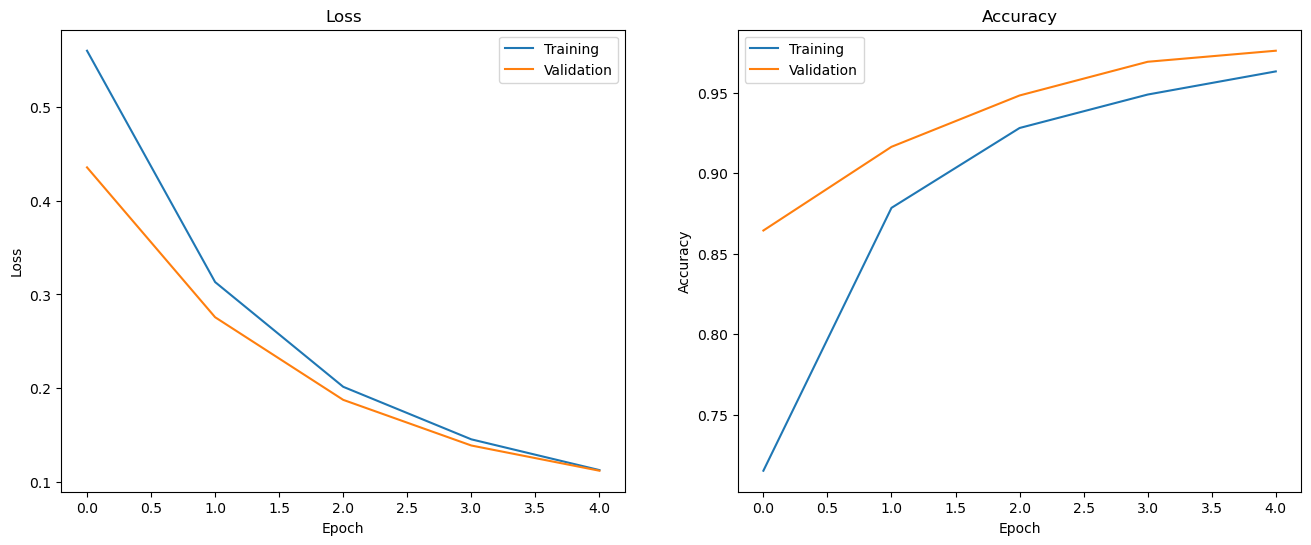

In [37]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history)
plt.plot(val_loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history)
plt.plot(val_accuracy_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')

In [38]:
# Evaluation
threshold = 0.5

test_loss = 0.0
test_accuracy = 0.0
batches = 0
for step, (image_batch, label_batch) in enumerate(ds_test):
    logits = model(image_batch, training=False)
    loss_value = criterion(label_batch, logits)

    # Metrics and Logging
    current_loss = loss_value.numpy()
    current_accuracy = accuracy_score(label_batch, logits > threshold)

    test_loss += current_loss
    test_accuracy += current_accuracy
    batches += 1

test_loss /= batches
test_accuracy /= batches

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss: 0.11548969858125144
Test Accuracy: 0.9597630718954248


In [39]:
model.save("pedestrian_detector_v4")

2023-01-15 17:45:28.382715: W tensorflow/python/util/util.cc:329] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: pedestrian_detector_v4/assets
